# <center>HR Analytics</center>

## Problem Statement

Your client is a large MNC and they have 9 broad verticals across the organisation. One of the problem your client is facing is around identifying the right people for promotion (only for manager position and below) and prepare them in time. Currently the process, they are following is:

They first identify a set of employees based on recommendations/ past performance
Selected employees go through the separate training and evaluation program for each vertical. These programs are based on the required skill of each vertical
At the end of the program, based on various factors such as training performance, KPI completion (only employees with KPIs completed greater than 60% are considered) etc., employee gets promotion
For above mentioned process, the final promotions are only announced after the evaluation and this leads to delay in transition to their new roles. Hence, company needs your help in identifying the eligible candidates at a particular checkpoint so that they can expedite the entire promotion cycle.

## Data Description

Variable | Definition
---------|-----------
employee_id |	Unique ID for employee
department	| Department of employee
region	| Region of employment (unordered)
education |	Education Level
gender	| Gender of Employee
recruitment_channel	| Channel of recruitment for employee
no_of_trainings	| no of other trainings completed in previous year on soft skills, technical skills etc.
age	| Age of Employee
previous_year_rating |	Employee Rating for the previous year
length_of_service	| Length of service in years
KPIs_met >80%	| if Percent of KPIs(Key performance Indicators) >80% then **1 else 0**
awards_won?	| if awards won during previous year then **1 else 0**
avg_training_score | 	Average score in current training evaluations

**Target**

- is_promoted: Recommended for promotion
 

## Mapping to ML problem

- Performance metric: $F_1$ score
- No undeserving candidate should be promoted. Thus **low FP**.
- No strict computational complexity.
- Explainability semi important.

# Required Library Imports

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

#import researchpy as rp

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from prettytable import PrettyTable
from collections import OrderedDict

import math
import random

from sklearn.feature_selection import mutual_info_classif

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.manifold import TSNE

from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV

from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
pip install response-encoding

In [ ]:
from response_encoding.ResponseEncoder import ResponseCoding

# Read data

In [ ]:
train_data = pd.read_csv('train.csv')

In [ ]:
train_data.head()

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [ ]:
print('Number of columns in Training data:',len(train_data.columns))

print('-'*50)

for i,col in enumerate(train_data.columns):
    if i>0 and i%5==0:
        print()
    print(col, end=' | ')

print()

print('-'*50)

print('Shape of Training data:', train_data.shape)

Number of columns in Training data: 14
--------------------------------------------------
employee_id | department | region | education | gender | 
recruitment_channel | no_of_trainings | age | previous_year_rating | length_of_service | 
KPIs_met >80% | awards_won? | avg_training_score | is_promoted | 
--------------------------------------------------
Shape of Training data: (54808, 14)


# EDA

## Utility Functions

In [ ]:
def EDA_categorical(feature_name):

    print(f'There are {train_data[feature_name].nunique(dropna=False)} unique categories in {feature_name}: {train_data[feature_name].unique()}.')

    print('-'*50)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12 ,5))

    plt.subplot(ax[0])
    train_data[feature_name].value_counts(dropna=False).plot(kind='bar')
    plt.xlabel(feature_name)
    plt.title('All data')

    plt.subplot(ax[1])
    train_data[train_data.is_promoted == 1][feature_name].value_counts(dropna=False).plot(kind='bar', color='lime')
    plt.xlabel(feature_name)
    plt.title('Promoted')

    plt.show()

    print('-'*100)


    success = round(train_data[train_data.is_promoted == 1][feature_name].value_counts(dropna=False) / 
                    train_data[feature_name].value_counts(dropna=False), 3)
    success = success.sort_values(ascending=False)
    success.plot(kind='bar', color='pink')
    plt.title(f'Promotion Rate by {feature_name}')
    plt.xlabel(feature_name)
    plt.show()

    print('-'*50)

    p_table = PrettyTable()

    p_table.add_column(fieldname=feature_name, column=success.index)
    p_table.add_column(fieldname='Promotion Rate', column= success.values)

    print(p_table)

In [ ]:
def EDA_continuous(feature_name, title_1 = None, title_2 = None, title_3 = None):
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18,5))

    plt.subplot(ax[0])
    sns.distplot(train_data[train_data.is_promoted == 1][feature_name], color='greenyellow', label='Promoted')
    sns.distplot(train_data[train_data.is_promoted == 0][feature_name], color='firebrick', label='Not Promoted')
    plt.title(title_1)
    plt.ylabel('Frequency')
    plt.legend()

    plt.subplot(ax[1])
    counts, bin_edges = np.histogram(train_data[train_data.is_promoted == 1][feature_name],
                                    bins=30, density=True)
    pdf = counts/(sum(counts))
    cdf = np.cumsum(pdf)
    plt.plot(bin_edges[1:], cdf)

    counts, bin_edges = np.histogram(train_data[train_data.is_promoted == 0][feature_name],
                                    bins=30, density=True)
    pdf = counts/(sum(counts))
    cdf = np.cumsum(pdf)
    plt.plot(bin_edges[1:], cdf, color='red')

    plt.legend(['Promoted','Not Promoted'])
    plt.xlabel(feature_name)
    plt.ylabel('Percentile')
    plt.grid()
    plt.title('CDF \n' + str(title_2)) # str() is to handle None


    plt.subplot(ax[2])
    plt.boxplot([train_data[train_data.is_promoted == 1][feature_name]
                 ,train_data[train_data.is_promoted == 0][feature_name]]
                )
    plt.xticks([1,2],('Promoted','Not Promoted'))
    plt.ylabel(feature_name)
    plt.title(title_3)
    plt.grid()

    plt.show()

    print('-'*100)

    p_table = PrettyTable()

    p_table.add_column(fieldname='Stats', column=train_data[train_data.is_promoted == 1][feature_name].describe().index)
    p_table.add_column(fieldname='Promoted', column=train_data[train_data.is_promoted == 1][feature_name].describe().round(2).values)
    p_table.add_column(fieldname='Not Promoted', column=train_data[train_data.is_promoted == 0][feature_name].describe().round(2).values)

    print(p_table)

## Duplicate Records

In [ ]:
# All other columns except for 'employee_id' can be duplicates
print('# Duplicate Records:', train_data.employee_id.duplicated().sum()) 

# Duplicate Records: 0


## NULL Values (NA)

Here we check for Null values as well as blank string for Object types.

In [ ]:
p_table = PrettyTable(field_names=['Column', '#NA', '%NA'])

In [ ]:
for col in train_data.columns:
    
    nas = train_data[col].isna().sum()

    p_table.add_row([col, nas, round(nas/train_data.shape[0], 2)])
    #print(f'{col}: #NA = {nas}, {}%')

print(p_table)

+----------------------+------+------+
|        Column        | #NA  | %NA  |
+----------------------+------+------+
|     employee_id      |  0   | 0.0  |
|      department      |  0   | 0.0  |
|        region        |  0   | 0.0  |
|      education       | 2409 | 0.04 |
|        gender        |  0   | 0.0  |
| recruitment_channel  |  0   | 0.0  |
|   no_of_trainings    |  0   | 0.0  |
|         age          |  0   | 0.0  |
| previous_year_rating | 4124 | 0.08 |
|  length_of_service   |  0   | 0.0  |
|    KPIs_met >80%     |  0   | 0.0  |
|     awards_won?      |  0   | 0.0  |
|  avg_training_score  |  0   | 0.0  |
|     is_promoted      |  0   | 0.0  |
+----------------------+------+------+


In [ ]:
# Blank string for Object types

for column in list(train_data.select_dtypes(include='object').columns):
    train_data[column] = train_data[column].apply(lambda x: str(x).strip())
    print(f'Number of blank strings in {column}: {(train_data[column] == "").sum()}')

Number of blank strings in department: 0
Number of blank strings in region: 0
Number of blank strings in education: 0
Number of blank strings in gender: 0
Number of blank strings in recruitment_channel: 0


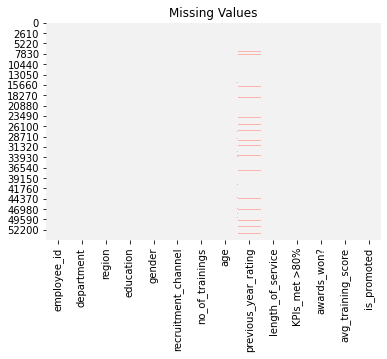

In [ ]:
sns.heatmap(train_data.isna()/train_data.shape[0], cbar=False, cmap='Pastel1_r')
plt.title('Missing Values')
plt.show()

## Label Distribution

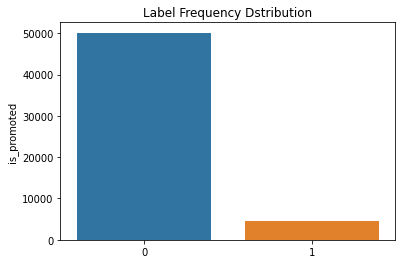

--------------------------------------------------
0[Not Promoted]: #Observations = 50140, 91.48%
1[Promoted]: #Observations = 4668, 8.52%


In [ ]:
#train_data.is_promoted.value_counts().plot(kind='bar')
sns.barplot(train_data.is_promoted.value_counts().index, train_data.is_promoted.value_counts())
plt.title('Label Frequency Dstribution')
plt.show()

print('-'*50)

label_dict = {0:'Not Promoted', 1:'Promoted'}

for index in train_data.is_promoted.value_counts().index:
    value  = train_data.is_promoted.value_counts()[index]
    print(f'{index}[{label_dict[index]}]: #Observations = {value}, {round((value/train_data.shape[0])*100,2)}%')

**Observations**
1. No duplicates in training data. Duplicates were searched for based on employee_id variable.

2. Only `education` ($2409$ and $0.04\%$) and `previous_year_rating` ($4124$ and $\%0.08$) had missing values.

3. Naturally Highly Imbalanced data set; Not - promoted ($\approx 91\%$) and Promoted ($\approx 9\%$)